# Machine Learning-Based Demand Forecasting
Seminararbeit von Benjamin Schwing


_Folgende Daten werden verwendet: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data_

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math

In [260]:
df_f = pd.read_csv("features.csv")
df_st = pd.read_csv("stores.csv")
df_train = pd.read_csv("train.csv")

In [261]:
df_f["Date"] = pd.to_datetime(df_f["Date"])
df_train["Date"] = pd.to_datetime(df_train["Date"])

### Überblick verschaffen

In [262]:
# Funktion zum Überblick verschaffen pro DataFrame
def seh_df(df, name):
    print(f"=== {name} ===")
    print("Spaltennamen:\n", df.columns.tolist())
    print("\nFehlende Werte:\n", df.isnull().sum())
    print("\nShape:\n", df.shape)
    print("\n" + "="*40 + "\n")


seh_df(df_f, "features.csv")
seh_df(df_st, "stores.csv")
seh_df(df_train, "train.csv")

=== features.csv ===
Spaltennamen:
 ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']

Fehlende Werte:
 Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

Shape:
 (8190, 12)


=== stores.csv ===
Spaltennamen:
 ['Store', 'Type', 'Size']

Fehlende Werte:
 Store    0
Type     0
Size     0
dtype: int64

Shape:
 (45, 3)


=== train.csv ===
Spaltennamen:
 ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

Fehlende Werte:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Shape:
 (421570, 5)




### Kombinieren der Daten

In [263]:
#Daten kombinieren
df_all_train = df_train.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_train = df_all_train.merge(df_st, how="left", on=["Store"])

In [264]:
print("Zeilen und Spalten: ", df_all_train.shape, "\nAlle Spalten im DF: ", df_all_train.columns.tolist())

Zeilen und Spalten:  (421570, 16) 
Alle Spalten im DF:  ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


## **Behandlung fehlender Werte**

In [265]:
# NULL/NaN-Werte finden

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'})
tab_info = pd.concat([tab_info, pd.DataFrame(df_all_train.isnull().sum()).T.rename(
    index={0:'null values (nb)'})], axis=0)
tab_info = pd.concat([tab_info, pd.DataFrame(df_all_train.isnull().sum()/df_all_train
    .shape[0]*100).T.rename(index={0:'null values (%)'})], axis=0)

#Temperature, Fuel_Price, CPI and Unemployment mit Durchschnitt ersetzen
df_all_train[["Temperature"]] = df_all_train[["Temperature"]].fillna(df_all_train[["Temperature"]].mean())
df_all_train[["Fuel_Price"]] = df_all_train[["Fuel_Price"]].fillna(df_all_train[["Fuel_Price"]].mean())
df_all_train[["CPI"]] = df_all_train[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_train[["Unemployment"]] = df_all_train[["Unemployment"]].fillna(df_all_train[["Unemployment"]].mean())

#Null/NaN-Werte für Markdown`s ersetzen mit 0
df_all_train = df_all_train.fillna(0)

#Testen ob alles funktioniert hat

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'Typ'})
tab_info = pd.concat([tab_info, pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null werte'})], axis=0)
tab_info = pd.concat([tab_info, pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.rename(index={0: 'null werte (%)'})], axis=0)


tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Typ,int64,int64,datetime64[ns],float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null werte,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null werte (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dummy Variablen erstellen für Store-Typ


In [266]:
df_all_train = pd.get_dummies(df_all_train, columns=["Type"])

## **Daten erkunden**

In [267]:
df_all_train.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328


### Externe Features

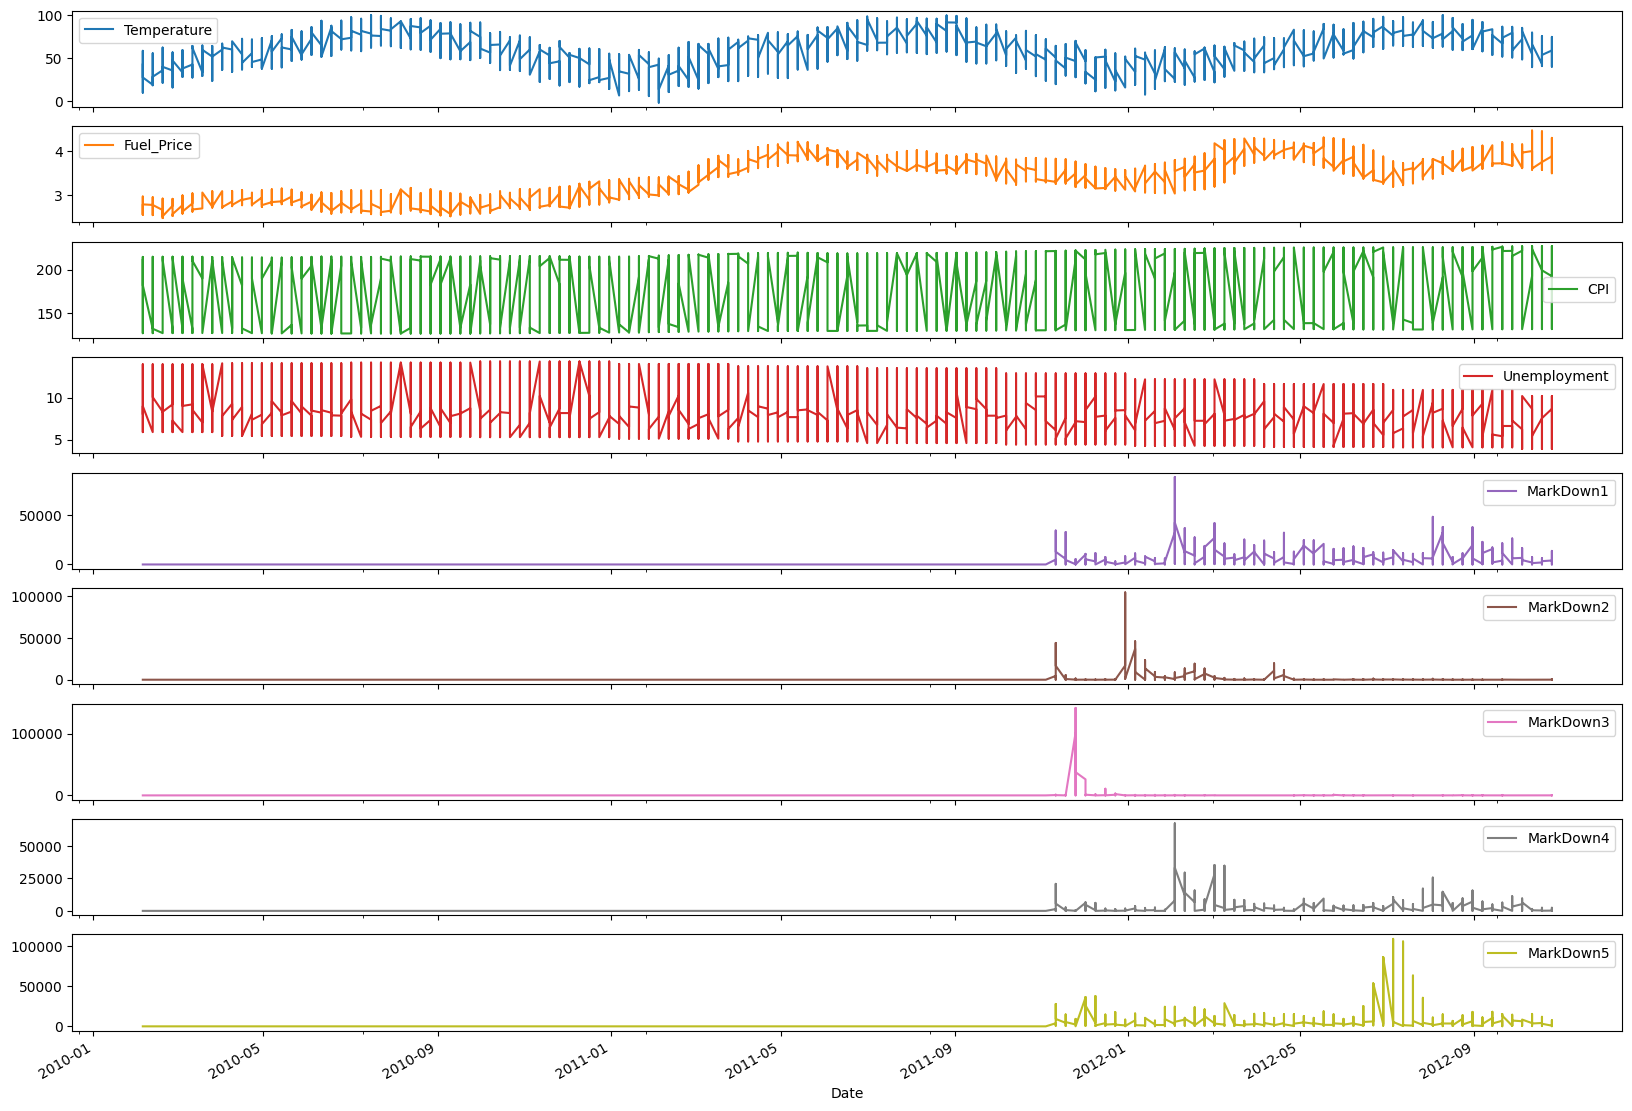

In [268]:
df_all_train[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

### Sales

<function matplotlib.pyplot.show(close=None, block=None)>

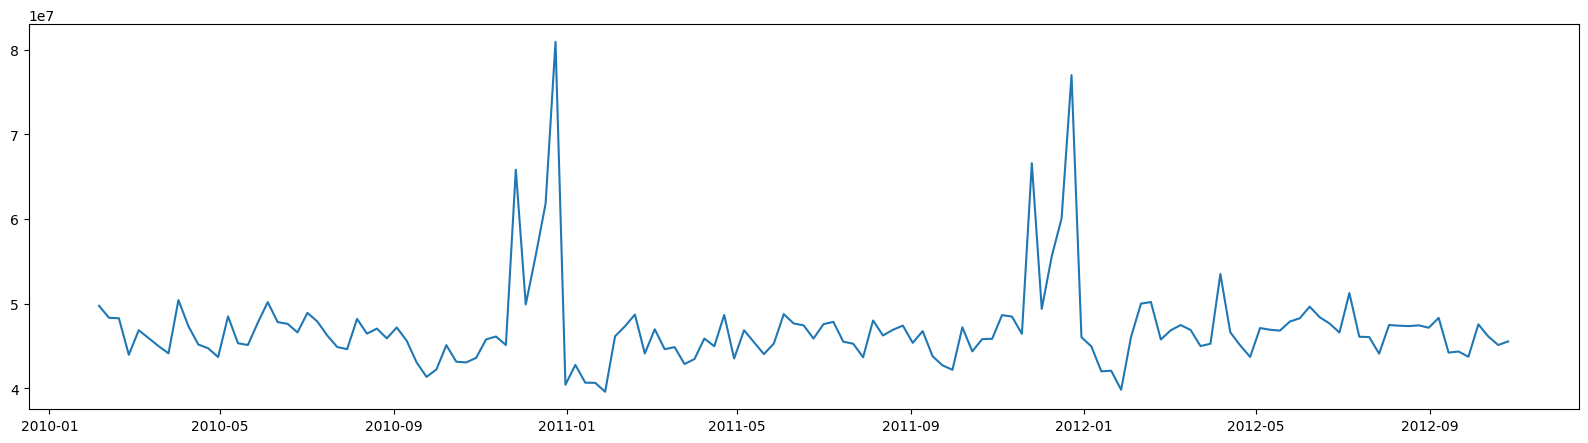

In [269]:
df_avg_verkauf_woech = df_all_train.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()


plt.figure(figsize=(20,5))
plt.plot(df_avg_verkauf_woech.Date, df_avg_verkauf_woech.Weekly_Sales)
plt.show

### Vorbereitung von Trainings- und Test-Sets

#### Dummy Variablen für Wochen

In [270]:
df_all_train["month"] = df_all_train['Date'].dt.month
df_all_train = df_all_train.drop(["Date"], axis=1)
df_all_train = pd.get_dummies(df_all_train, columns=["month"])


#### Aufteilen der Daten in Training- und Test-Sets

In [271]:
train_x = df_all_train.drop("Weekly_Sales", axis=1)
train_y = df_all_train["Weekly_Sales"]

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, shuffle=False, stratify=None)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

### Zeit Sequenz für LSTM und CNN-LSTM


In [272]:
def create_sequences(x, y, time_steps=4):
    x_seq, y_seq = [], []
    for i in range(len(x) - time_steps):
        x_seq.append(x[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(x_seq), np.array(y_seq)

x_train_arr = np.array(x_train_scaled)
y_train_arr = np.array(y_train)
x_test_arr = np.array(x_test_scaled)
y_test_arr = np.array(y_test)

time_steps = 4
X_train_seq, y_train_seq = create_sequences(x_train_arr, y_train_arr, time_steps)
X_test_seq, y_test_seq = create_sequences(x_test_arr, y_test_arr, time_steps)

### RMSE Vorbereitung

In [273]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

model_rmse = {}

# Implementation der Modelle

In [274]:
#imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.layers import Input, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression



#GPU Konfiguration, da sie bei meinem Laptop schneller ist als die CPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### LSTM

In [275]:
# LSTM

def train_lstm():
    print("Trainiere LSTM Modell...")

    # LSTM-Modell definieren
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])

    # Modell kompilieren
    lstm_model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Modell trainieren
    lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Vorhersagen machen
    y_pred_lstm = lstm_model.predict(X_test_seq).flatten()

    # RMSE berechnen
    rmse_lstm = calculate_rmse(y_test_seq, y_pred_lstm)
    model_rmse['LSTM'] = rmse_lstm

    print(f"LSTM RMSE: {rmse_lstm}")
    return lstm_model, y_pred_lstm

# LSTM-Modell trainieren
lstm_model, y_pred_lstm = train_lstm()

Trainiere LSTM Modell...
Epoch 1/50
8432/8432 [==============================] - 87s 10ms/step - loss: 621755456.0000 - val_loss: 349006816.0000
Epoch 2/50
8432/8432 [==============================] - 132s 16ms/step - loss: 443334816.0000 - val_loss: 297399360.0000
Epoch 3/50
8432/8432 [==============================] - 107s 13ms/step - loss: 374121952.0000 - val_loss: 267628256.0000
Epoch 4/50
8432/8432 [==============================] - 43s 5ms/step - loss: 336757696.0000 - val_loss: 281719616.0000
Epoch 5/50
8432/8432 [==============================] - 22s 3ms/step - loss: 312125856.0000 - val_loss: 268741728.0000
Epoch 6/50
8432/8432 [==============================] - 23s 3ms/step - loss: 278372480.0000 - val_loss: 269037024.0000
Epoch 7/50
8432/8432 [==============================] - 57s 7ms/step - loss: 259002848.0000 - val_loss: 279709216.0000
Epoch 8/50
2635/2635 [==============================] - 3s 1ms/step
LSTM RMSE: 19204.008190680375


### Ensemble-Methoden

In [276]:
# Ensemble-Methoden

def train_ensemble_methods():
    print("Trainiere Random Forest Modell...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred_rf = rf_model.predict(x_test)
    rmse_rf = calculate_rmse(y_test, y_pred_rf)
    model_rmse['Random Forest'] = rmse_rf
    print(f"Random Forest RMSE: {rmse_rf}")

    print("Training Gradient Boosting Modell...")
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(x_train, y_train)
    y_pred_gb = gb_model.predict(x_test)
    rmse_gb = calculate_rmse(y_test, y_pred_gb)
    model_rmse['Gradient Boosting'] = rmse_gb
    print(f"Gradient Boosting RMSE: {rmse_gb}")

    return {"Random Forest": (rf_model, y_pred_rf), "Gradient Boosting": (gb_model, y_pred_gb)}

# Modelle trainieren
ensemble_models = train_ensemble_methods()

Trainiere Random Forest Modell...
Random Forest RMSE: 9443.847905479019
Training Gradient Boosting Modell...
Gradient Boosting RMSE: 10321.631064696543


### Transformer

In [277]:
# Transformer

def train_transformer():
    print("Trainiere Transformer Modell...")

    # Transformer-Modell definieren
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

    inputs = Input(shape=input_shape)

    # Multi-head Attention Layer
    attention_output = MultiHeadAttention(
        num_heads=2, key_dim=64
    )(inputs, inputs)

    # Dense Layer hinzufügen
    x = Dense(64, activation='relu')(attention_output)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)

    # Finale Dense Layer
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Modell kompilieren
    transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Modell trainieren
    history = transformer_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Vorhersagen machen
    y_pred_transformer = transformer_model.predict(X_test_seq).flatten()

    # RMSE berechnen
    rmse_transformer = calculate_rmse(y_test_seq, y_pred_transformer)
    model_rmse['Transformer'] = rmse_transformer

    print(f"Transformer RMSE: {rmse_transformer}")
    return transformer_model, y_pred_transformer

# Transformer-Modell trainieren
transformer_model, y_pred_transformer = train_transformer()

Trainiere Transformer Modell...
Epoch 1/50
8432/8432 [==============================] - 17s 2ms/step - loss: 536072832.0000 - val_loss: 324038496.0000
Epoch 2/50
8432/8432 [==============================] - 70s 8ms/step - loss: 504963840.0000 - val_loss: 343588352.0000
Epoch 3/50
8432/8432 [==============================] - 77s 9ms/step - loss: 487846176.0000 - val_loss: 415473632.0000
Epoch 4/50
8432/8432 [==============================] - 78s 9ms/step - loss: 480621056.0000 - val_loss: 619749440.0000
Epoch 5/50
8432/8432 [==============================] - 26s 3ms/step - loss: 472896192.0000 - val_loss: 2365673216.0000
Epoch 6/50
8432/8432 [==============================] - 37s 4ms/step - loss: 462844352.0000 - val_loss: 6107148288.0000
Epoch 7/50
8432/8432 [==============================] - 45s 5ms/step - loss: 459081600.0000 - val_loss: 6692700672.0000
Epoch 8/50
8432/8432 [==============================] - 12s 1ms/step - loss: 457388320.0000 - val_loss: 9004529664.0000
Epoch 9/50
8

### CNN-LSTM

In [278]:
# CNN-LSTM

def train_cnn_lstm():
    print("Trainiere CNN-LSTM Modell...")

    # CNN-LSTM-Modell definieren
    cnn_lstm_model = Sequential([
        # CNN Layer
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),

        # LSTM Layer
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),

        # Dense Layer
        Dense(25, activation='relu'),
        Dense(1)
    ])

    # Modell kompilieren
    cnn_lstm_model.compile(optimizer='adam', loss='mse')

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Modell trainieren
    history = cnn_lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Vorhersagen machen
    y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_seq).flatten()

    # RMSE berechnen
    rmse_cnn_lstm = calculate_rmse(y_test_seq, y_pred_cnn_lstm)
    model_rmse['CNN-LSTM'] = rmse_cnn_lstm

    print(f"CNN-LSTM RMSE: {rmse_cnn_lstm}")
    return cnn_lstm_model, y_pred_cnn_lstm

# CNN-LSTM-Modell trainieren
cnn_lstm_model, y_pred_cnn_lstm = train_cnn_lstm()

Trainiere CNN-LSTM Modell...
Epoch 1/50
8432/8432 [==============================] - 35s 4ms/step - loss: 669110272.0000 - val_loss: 326871424.0000
Epoch 2/50
8432/8432 [==============================] - 30s 4ms/step - loss: 458115072.0000 - val_loss: 427568512.0000
Epoch 3/50
8432/8432 [==============================] - 30s 4ms/step - loss: 406804544.0000 - val_loss: 437431936.0000
Epoch 4/50
8432/8432 [==============================] - 30s 4ms/step - loss: 372262272.0000 - val_loss: 459920096.0000
Epoch 5/50
8432/8432 [==============================] - 30s 4ms/step - loss: 341947072.0000 - val_loss: 324297280.0000
Epoch 6/50
8432/8432 [==============================] - 31s 4ms/step - loss: 313583328.0000 - val_loss: 324124960.0000
Epoch 7/50
8432/8432 [==============================] - 29s 3ms/step - loss: 291988096.0000 - val_loss: 352549632.0000
Epoch 8/50
8432/8432 [==============================] - 29s 3ms/step - loss: 282865280.0000 - val_loss: 302354752.0000
Epoch 9/50
8432/843

### lineare Regression

In [281]:
# Lineare Regression

def train_linear_regression():
    print("Trainiere Linear Regression Modell...")
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    y_pred_lr = lr_model.predict(x_test)

    rmse_lr = calculate_rmse(y_test, y_pred_lr)
    model_rmse['Linear Regression'] = rmse_lr

    print(f"Linear Regression RMSE: {rmse_lr}")
    return lr_model, y_pred_lr

lr_model, y_pred_lr = train_linear_regression()

Trainiere Linear Regression Modell...
Linear Regression RMSE: 18497.815280804047


# Analyse


=== Modellvergleich ===
LSTM: RMSE = 19204.008190680375
Random Forest: RMSE = 9443.847905479019
Gradient Boosting: RMSE = 10321.631064696543
Transformer: RMSE = 18136.802403326754
CNN-LSTM: RMSE = 17438.463532018068
Linear Regression: RMSE = 18497.815280804047


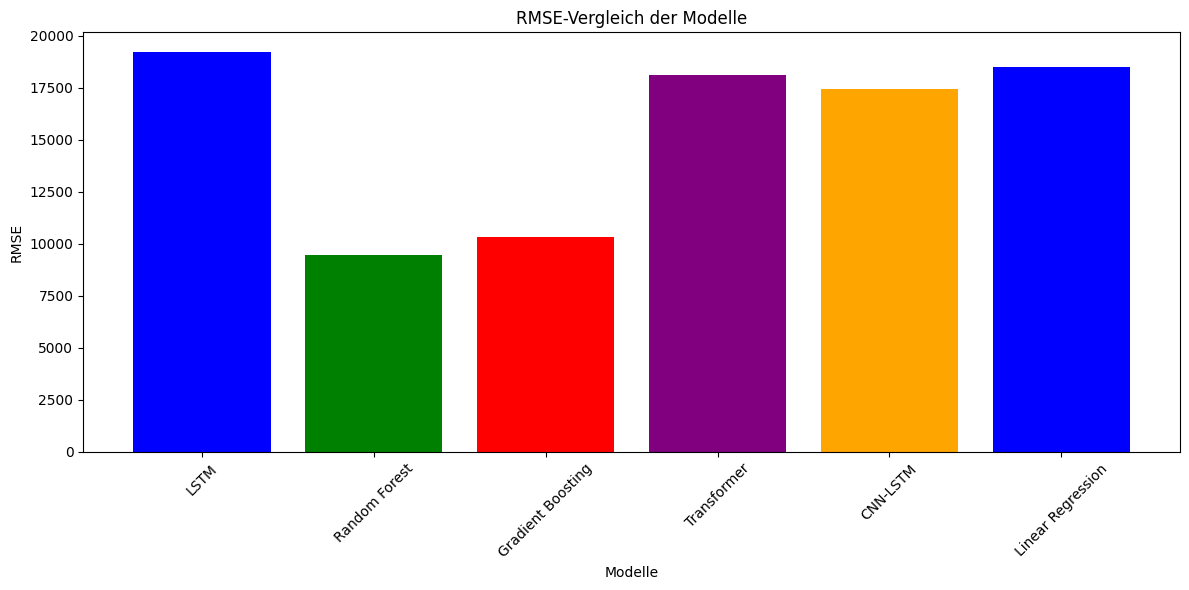


Bestes Modell: Random Forest mit RMSE = 9443.847905479019


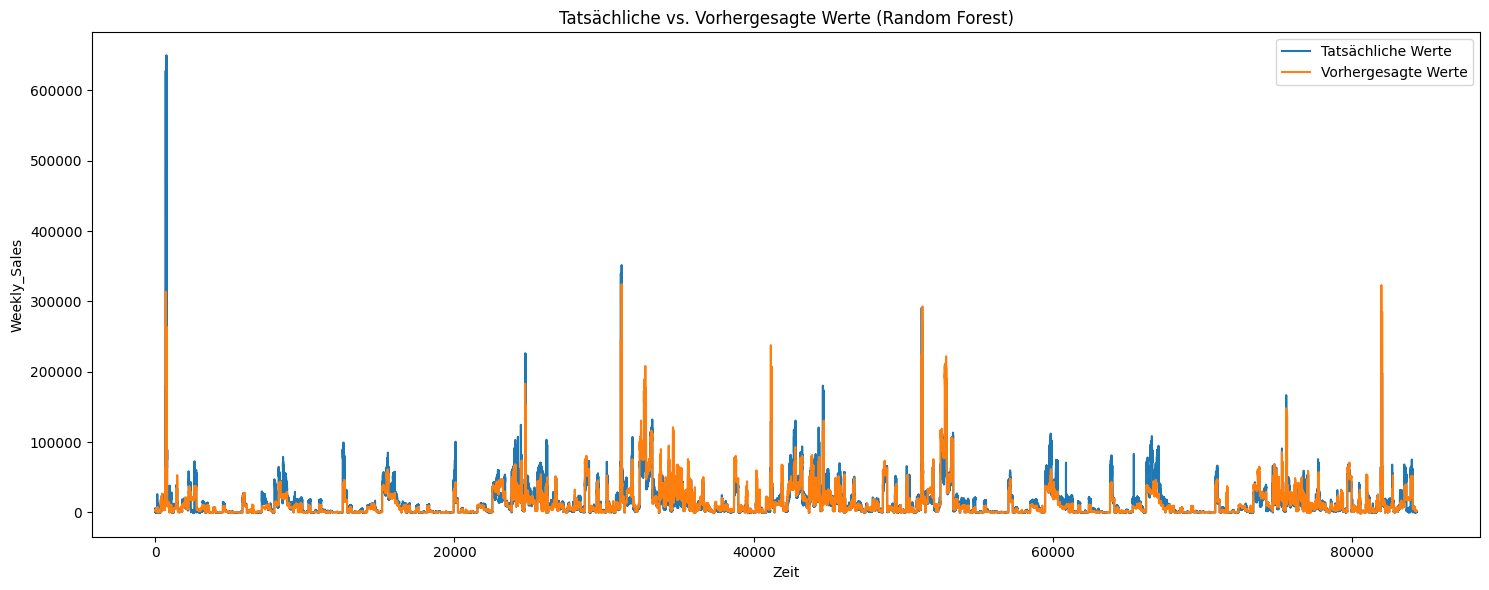

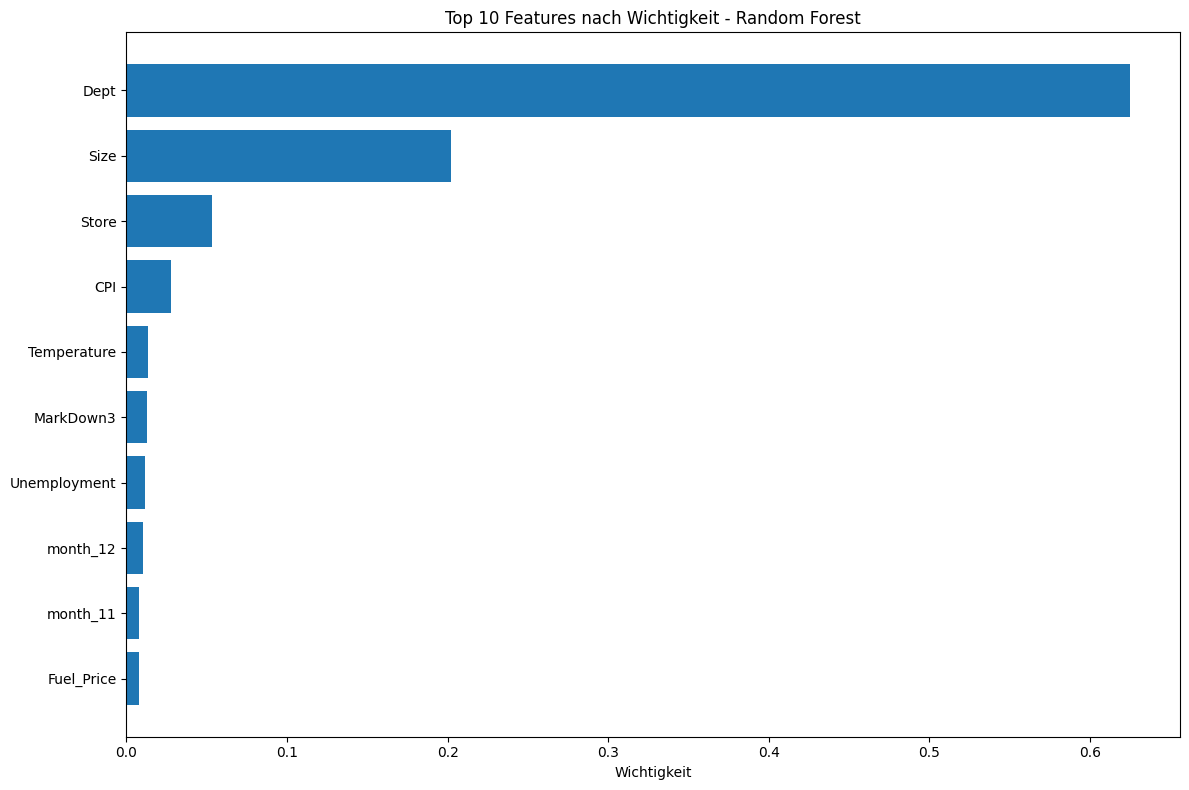


=== Zusammenfassung ===
Das beste Modell für die Demand Forecasting ist Random Forest mit einem RMSE von 9443.85

RMSE-Werte aller Modelle (sortiert):
Random Forest: 9443.85
Gradient Boosting: 10321.63
CNN-LSTM: 17438.46
Transformer: 18136.80
Linear Regression: 18497.82
LSTM: 19204.01


In [292]:
# RMSE-Werte vergleichen
print("\n=== Modellvergleich ===")
for modell_name, rmse in model_rmse.items():
    print(f"{modell_name}: RMSE = {rmse}")

# RMSE-Vergleich plotten
plt.figure(figsize=(12, 6))
models = list(model_rmse.keys())
rmse_values = list(model_rmse.values())

plt.bar(models, rmse_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('RMSE-Vergleich der Modelle')
plt.xlabel('Modelle')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bestes Modell finden
bestes_modell = min(model_rmse, key=model_rmse.get)
print(f"\nBestes Modell: {bestes_modell} mit RMSE = {model_rmse[bestes_modell]}")

# Vorhersagen für das beste Modell plotten
plt.figure(figsize=(15, 6))
if bestes_modell == 'Linear Regression':
    plt.plot(y_test.values, label='Tatsächliche Werte')
    plt.plot(y_pred_lr, label='Vorhergesagte Werte')
elif bestes_modell == 'Random Forest':
    plt.plot(y_test.values, label='Tatsächliche Werte')
    plt.plot(ensemble_models['Random Forest'][1], label='Vorhergesagte Werte')
elif bestes_modell == 'Gradient Boosting':
    plt.plot(y_test.values, label='Tatsächliche Werte')
    plt.plot(ensemble_models['Gradient Boosting'][1], label='Vorhergesagte Werte')
else:
    if bestes_modell == 'LSTM':
        plt.plot(y_test_seq, label='Tatsächliche Werte')
        plt.plot(y_pred_lstm, label='Vorhergesagte Werte')
    elif bestes_modell == 'Transformer':
        plt.plot(y_test_seq, label='Tatsächliche Werte')
        plt.plot(y_pred_transformer, label='Vorhergesagte Werte')
    elif bestes_modell == 'CNN-LSTM':
        plt.plot(y_test_seq, label='Tatsächliche Werte')
        plt.plot(y_pred_cnn_lstm, label='Vorhergesagte Werte')

plt.title(f'Tatsächliche vs. Vorhergesagte Werte ({bestes_modell})')
plt.xlabel('Zeit')
plt.ylabel('Weekly_Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Feature Wichtigkeit für traditionelle Modelle
if bestes_modell in ['Linear Regression', 'Random Forest', 'Gradient Boosting']:
    plt.figure(figsize=(12, 8))

    if bestes_modell == 'Linear Regression':
        importance = np.abs(lr_model.coef_)
        feature_names = x_train.columns
    elif bestes_modell == 'Random Forest':
        importance = ensemble_models['Random Forest'][0].feature_importances_
        feature_names = x_train.columns
    elif bestes_modell == 'Gradient Boosting':
        importance = ensemble_models['Gradient Boosting'][0].feature_importances_
        feature_names = x_train.columns

    # Merkmale nach Wichtigkeit sortieren
    indices = np.argsort(importance)[-10:]  # Top 10 Merkmale nehmen
    plt.barh(range(len(indices)), importance[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f'Top 10 Features nach Wichtigkeit - {bestes_modell}')
    plt.xlabel('Wichtigkeit')
    plt.tight_layout()
    plt.show()

# Zusammenfassung der Ergebnisse
print("\n=== Zusammenfassung ===")
print(f"Das beste Modell für die Demand Forecasting ist {bestes_modell} mit einem RMSE von {model_rmse[bestes_modell]:.2f}")
print("\nRMSE-Werte aller Modelle (sortiert):")
sorted_models = sorted(model_rmse.items(), key=lambda x: x[1])
for model, rmse in sorted_models:
    print(f"{model}: {rmse:.2f}")